# Evaluation of fine-tuned models

## Generation of evaluation set

This will be composed of combinations of list of genes, list of compounds and matching pathway (=target).
These will be drawn from kegg dataset.

### Loading required packages, functions and database

In [1]:
import json
import random
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("MISTRAL_API_KEY")

In [76]:
def draw_gene_cpd(db, pathway):
    '''
    From a kegg pathway entry, draw a random list of genes and compounds involved, of varying length
    :param db: dict from the json file containing kegg database information
    :param pathway: string, pathway code
    :return: (gene, cpd) tuple of lists
    '''
    p_genes = db[pathway]['genes']
    limit = min(25, len(p_genes))
    n_genes = random.randint(2, limit)
    gene = random.sample(p_genes, n_genes)
    p_cpd = db[pathway]['compounds']
    limit = min(25, len(p_cpd))
    n_cpd = random.randint(2, limit)
    cpd = random.sample(p_cpd, n_cpd)
    return (gene, cpd)

def draw_example(db, pathway_vc):
    '''
    Randomly pick a pathway entry from the kegg json file, and draw gene and cpd from it.
    Value count (vc) for each pathway ensure the dataset is balanced.
    :param db: kegg database json with pathways, genes and compounds
    :param pathway_vc: dict containing the number of example already drawn per pathway
    :return: (pathway, gene, cpd) tuple of lists
    '''
    pathway = list(db.keys())[0]
    if sum(pathway_vc.values()) < 176:
        while pathway_vc[pathway] >= 2:
            pathway = random.choice(list(db.keys()))
    pathway_vc[pathway] = pathway_vc[pathway]+1
    name = db[pathway]["name"]
    gene, cpd = draw_gene_cpd(db, pathway)
    return (name, gene, cpd, pathway_vc)
    
def create_pathway_valuecount():
    '''
    Create a pathway_vc.csv file containing the list of pathway codes and initial value counts (0)
    '''
    keggdf = pd.read_json('prompts/pathway_genes_compoundsrf.json', orient='index')
    vc = {}
    pvc = {}
    for i in keggdf.index:
        name = keggdf.loc[i, 'name']
        if name in vc :
            pvc[i] = vc[name]
        else :
            pvc[i] = 0
    pvc = pd.DataFrame.from_dict(pvc, orient='index', columns=['count'])
    pvc.to_csv('test/pathway_vc.csv', index_label='pathway_code')

def make_test_item(tuple):
    '''
    calls previous methods to make an exemple, and return the output as a json formatted file
    :param tuple: (pathway, gene, cpd) tuple
    :return: dict, json formatted
    '''
    pathway, gene, cpd = tuple
    item = {}
    item["input"] = {"genes" : gene,
                        "cpd" : cpd}
    item["target"] = pathway
    print(f'{pathway} : {len(gene)} Genes and {len(cpd)} compounds.')
    return item

In [4]:
with open('prompts/pathway_genes_compoundsrf.json', 'r') as jsonfile:
    db = json.load(jsonfile)
len(db)

88

### Creating a balanced test dataset

In [71]:
create_pathway_valuecount()

In [77]:
pathway_vc = pd.read_csv('test/pathway_vc.csv', index_col='pathway_code').to_dict()['count']
len(pathway_vc)

88

In [78]:
with open('test/test.jsonl', 'w', encoding='utf-8') as f:
    for i in range(200):
        print(i)
        name, gene, cpd, pathway_vc = draw_example(db, pathway_vc)
        data_ex = (name, gene, cpd)
        ex = make_test_item(data_ex)
        json.dump(ex, f, ensure_ascii=False)
        f.write('\n')

0
Carbon metabolism : 2 Genes and 15 compounds.
1
Carbon metabolism : 16 Genes and 22 compounds.
2
Glycosaminoglycan degradation : 11 Genes and 6 compounds.
3
Fatty acid metabolism : 25 Genes and 15 compounds.
4
Valine, leucine and isoleucine degradation : 16 Genes and 8 compounds.
5
Valine, leucine and isoleucine degradation : 23 Genes and 23 compounds.
6
Phenylalanine, tyrosine and tryptophan biosynthesis : 4 Genes and 18 compounds.
7
Fatty acid degradation : 10 Genes and 14 compounds.
8
Primary bile acid biosynthesis : 14 Genes and 20 compounds.
9
Mucin type O-glycan biosynthesis : 16 Genes and 5 compounds.
10
Mannose type O-glycan biosynthesis : 7 Genes and 6 compounds.
11
Glyoxylate and dicarboxylate metabolism : 2 Genes and 14 compounds.
12
Biosynthesis of amino acids : 11 Genes and 12 compounds.
13
Fatty acid metabolism : 14 Genes and 5 compounds.
14
Propanoate metabolism : 17 Genes and 8 compounds.
15
Alanine, aspartate and glutamate metabolism : 16 Genes and 23 compounds.
16
T

In [81]:
print(sum(pathway_vc.values()))

200


## Interrogation of the models with the test dataset

To be fair with the different models, a system prompt is added, in order to set the following guidelines :
* Find the altered pathway
* <200 words
Models were challenged with the test dataset using evaluation.py script.
Following models were used :

In [3]:
entries = []
with open("test/test_pass.jsonl", 'r') as infile:
    for line in infile:
        try:
            entry = json.loads(line)
            entries.append(entry)
        except json.JSONDecodeError:
            print(f"Ignoring invalid JSON: {line}")
len(entries)

200

In [4]:
entries[0]

{'input': {'genes': ['PCCA', 'PGAM1'],
  'cpd': ['Tetrahydrosarcinapterin',
   'D-Xylulose 5-phosphate',
   'CO2',
   'L-erythro-3-Methylmalyl-CoA',
   '2-Phosphoglycolate',
   '5-Formyl-5,6,7,8-tetrahydromethanopterin',
   'L-Serine',
   'D-Glucono-1,5-lactone 6-phosphate',
   'Glycolate',
   'D-Glucono-1,5-lactone',
   'D-Fructose 6-phosphate',
   'D-Gluconic acid',
   'Glycerone',
   'D-Glycerate',
   '4-Hydroxybutyryl-CoA']},
 'target': 'Carbon metabolism',
 'output': {'open-mistral-7b': 'The altered pathway involves the genes PCCA and PGAM1, which are associated with the glyoxylate cycle and the glycolysis pathway, respectively.\n\nThe glyoxylate cycle is a metabolic pathway that occurs in some microorganisms, plants, and animals. It allows these organisms to convert acetyl-CoA derived from fatty acids into glucose-6-phosphate, providing a means of glucose production when glucose is limited. The cycle involves two key enzymes, ISOCITRATE LYASE (ICL) and MALATE SYNTHASE (MLS), whic

## Scoring of the models : LLM as a judge

In order to score models performance on test dataset, I used mistral-large-latest model together with a list of metrics and rubrics. Large model was instructed to send back a json file containing the scores. Following metrics were used :

Scoring was performed using scoring.py script.

In [9]:
# Initialize a list to store the data
data_list = []

# Read the JSONL file
with open('test/test_eval2.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        for llm, scores in data.items():
            scores['LLM'] = llm
            data_list.append(scores)

# Create the DataFrame
df = pd.DataFrame(data_list)

# Reorder columns
df = df[['LLM', 'accuracy', 'informativity', 'format']]

# Display the DataFrame
print(df)

       LLM  accuracy  informativity  format
0    LLM 1         2              3       2
1    LLM 2         2              3       3
2    LLM 3         2              3       3
3    LLM 4         2              3       3
4    LLM 1         2              3       3
..     ...       ...            ...     ...
795  LLM 4         3              3       3
796  LLM 1         2              3       2
797  LLM 2         2              3       3
798  LLM 3         2              3       3
799  LLM 4         2              3       3

[800 rows x 4 columns]


In [24]:
df = df.replace('LLM 1', 'mistral-7b')
df = df.replace('LLM 2', 'fine-tune-1')
df = df.replace('LLM 3', 'fine-tune-2')
df = df.replace('LLM 4', 'mistral-small')

In [40]:
sums = df.groupby(by=df["LLM"]).sum()
sums = sums.reset_index()
print(sums)

             LLM  accuracy  informativity  format
0    fine-tune-1       565            561     595
1    fine-tune-2       553            579     598
2     mistral-7b       480            529     524
3  mistral-small       537            540     585


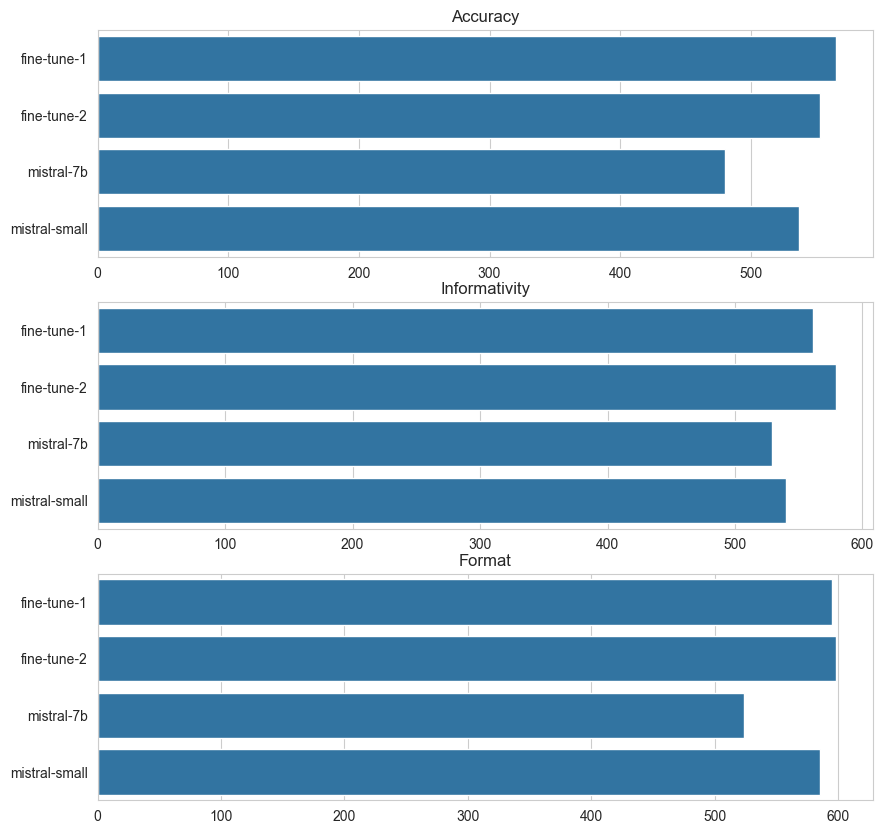

In [38]:
plt.figure(figsize=(10, 10))

metrics = ['accuracy', 'informativity', 'format']

for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i+1)
    sns.barplot(x=metric, y='LLM', data=sums, legend=False)
    plt.title(f'{metric.capitalize()}')
    plt.xlabel('')
    plt.ylabel('')

plt.savefig('metrics_comparison.png', dpi=300)
plt.show()

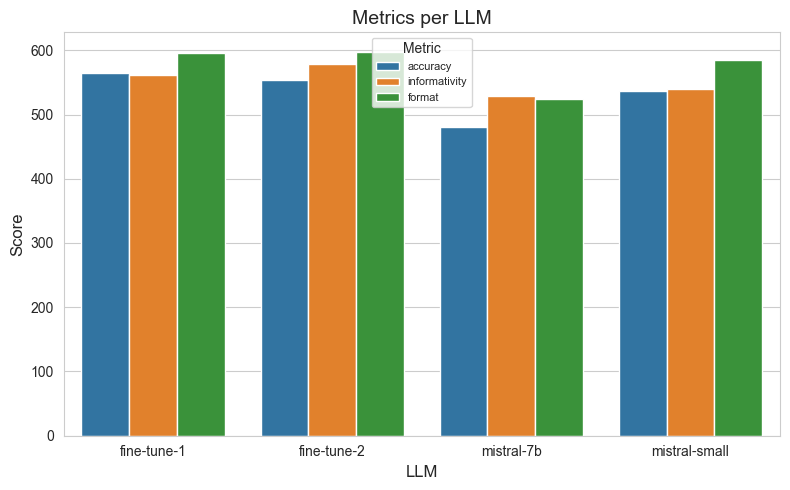

In [54]:
plt.figure(figsize=(8, 5))
sums_melted = sums.melt(id_vars=['LLM'], var_name='Metric', value_name='Score')
sns.barplot(x='LLM', y='Score', hue='Metric', data=sums_melted)
plt.title('Metrics per LLM', fontsize=14)
plt.xlabel('LLM', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(title='Metric', title_fontsize='10', fontsize='8')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('combined_graph.png', dpi=300, bbox_inches='tight')
plt.show()

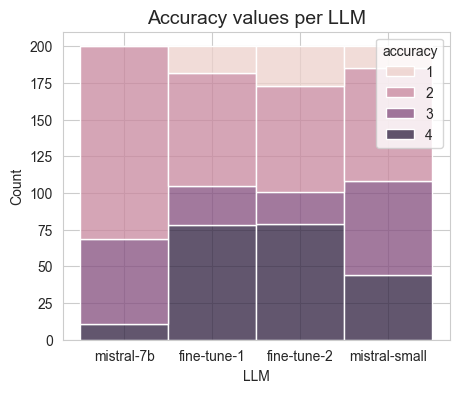

In [55]:
plt.figure(figsize=(5, 4))
sns.histplot(df,
    x="LLM", hue="accuracy",
    multiple="stack")
plt.title('Accuracy values per LLM', fontsize=14)
plt.savefig('accuracy_values.png', dpi=300, bbox_inches='tight')
plt.show()